## Data Mining Techniques
### COVID-19 data
Kimberley Boersma (2572145), Neil Mizzi (2674737), Selma Muhammad (2578081)

In [1]:
# Imports
import os
import pandas as pd
import csv
import kaggle

# other imports
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from copy import copy
import seaborn as sns
from scipy.stats import norm
import matplotlib.dates as mdates
# import matplotlib.colors as mcolors
# import random
# import math
# import time
# from sklearn.linear_model import LinearRegression, BayesianRidge
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
# from sklearn.svm import SVR
from datetime import date, datetime
from dateutil.parser import parse
import us
# import operator 
# plt.style.use('fivethirtyeight')
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline 

# Covid Tracking Dataset (w/ hospitalised data)

Source: https://covidtracking.com/

## Step 1: Load and Clean the Data

In [2]:
all_cases = pd.read_csv('https://covidtracking.com/api/v1/states/daily.csv')

# Delete unecessary rows
for row in ['negative', 'pending', 'hash', 'negativeIncrease', 'totalTestResults', 'totalTestResultsIncrease', 'dateChecked', 'fips', 'inIcuCumulative', 'onVentilatorCumulative', 'total', 'posNeg', 'deathIncrease', 'hospitalizedIncrease', 'positiveIncrease']:
    del all_cases[row]

# TODO missing values
#      Do we get avg or missing values, or predict them?
#      See https://developerzen.com/data-mining-handling-missing-values-the-database-bd2241882e72

for i, row in all_cases.iterrows():
    # Set Dates
    s = str(row['date'])
    all_cases.at[i, 'date'] = date(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8]))

# Missing death figures means no death reports yet
# These are set to 0
for i, row in all_cases.iterrows():
    if np.isnan(row['death']):
        all_cases.at[i, 'death'] = 0

In [3]:
all_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4273 entries, 0 to 4272
Data columns (total 12 columns):
date                      4273 non-null object
state                     4273 non-null object
positive                  4258 non-null float64
hospitalizedCurrently     1915 non-null float64
hospitalizedCumulative    1796 non-null float64
inIcuCurrently            1003 non-null float64
onVentilatorCurrently     817 non-null float64
recovered                 1744 non-null float64
dataQualityGrade          3160 non-null object
lastUpdateEt              3918 non-null object
death                     4273 non-null float64
hospitalized              1796 non-null float64
dtypes: float64(8), object(4)
memory usage: 400.7+ KB


## Missing values: Retrieving from other datasets or through merging columns (or both)

The following will be done:
- **Active Cases**: Retrieved from JHU dataset and calculating $active = pos-dead-recovered$
- **Beds per State**: Retrieved from External Datasets

In [4]:
# TODO Replace active cases with JHU and/or regression model (Selma)
all_cases['active'] = all_cases['positive'] - all_cases['recovered'] - all_cases['death']
# change location of 'active' column
cols = list(all_cases)
cols.insert(3, cols.pop(cols.index('active')))
all_cases = all_cases.loc[:, cols]

In [5]:
# Load datasets for US population and Hospital beds per 1000
us_population = pd.read_csv('data/us_population.csv')
hosp_beds = pd.read_csv('data/hospital_beds.csv')
state_abbrev = pd.read_csv('data/us_state_names.csv')

# add state abbreviations to us_population and hospital beds dataframe
for state in state_abbrev['State'].tolist():
    # store state abbreviation in variable
    abbrev = state_abbrev.loc[state_abbrev['State'] == state, 'Abbreviation'].tolist()[0]
    # add abbrev to new column 'Abbreviation' in us_population df
    us_population.loc[us_population['State'] == state, 'Abbreviation'] = abbrev
    # add abbrev to new column in hosp_beds df
    hosp_beds.loc[hosp_beds['Location'] == state, 'Abbreviation'] = abbrev
    
# change order of columns of us_population
cols = list(us_population)
cols.insert(2, cols.pop(cols.index('Abbreviation')))
us_population = us_population.loc[:, cols]

# drop unnecessary columns of us_population
us_population = us_population.drop(columns=['rank', 'Growth', 'Pop2018', 'Pop2010', 'growthSince2010', 'Percent', 'density'])

# drop unnecessary columns of hosp_beds
hosp_beds = hosp_beds.drop(columns=['Location', 'State/Local Government', 'Non-Profit', 'For-Profit'])

# change order of columns of hosp_beds
cols = list(hosp_beds)
cols.insert(0, cols.pop(cols.index('Abbreviation')))
hosp_beds = hosp_beds.loc[:, cols]

In [6]:
us_population.head()

,State,Abbreviation,Pop
0,Alabama,AL,4908621
1,Alaska,AK,734002
2,Arizona,AZ,7378494
3,Arkansas,AR,3038999
4,California,CA,39937489


In [7]:
hosp_beds.head()

,Abbreviation,Total
0,NaN,2.4
1,AL,3.1
2,AK,2.2
3,AZ,1.9
4,AR,3.2


In [8]:
# filter out non-existing states like 'AS'
all_cases = all_cases[all_cases['state'].isin(state_abbrev['Abbreviation'].tolist())]

In [9]:
# see what filtered dataframe looks like
all_cases.head()

,date,state,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,recovered,dataQualityGrade,lastUpdateEt,death,hospitalized
0,2020-05-20,AK,402.0,40.0,16.0,NaN,NaN,NaN,352.0,C,5/20/2020 00:00,10.0,NaN
1,2020-05-20,AL,12744.0,NaN,NaN,1493.0,NaN,NaN,NaN,B,5/19/2020 00:00,517.0,1493.0
2,2020-05-20,AR,5003.0,1044.0,78.0,535.0,NaN,14.0,3852.0,A,5/20/2020 00:00,107.0,535.0
4,2020-05-20,AZ,14897.0,10377.0,810.0,1792.0,298.0,208.0,3773.0,A+,5/20/2020 00:00,747.0,1792.0
5,2020-05-20,CA,84057.0,NaN,4681.0,NaN,1345.0,NaN,NaN,B,5/20/2020 00:00,3436.0,NaN


In [10]:
# check which states have 0 positive cases
all_cases.loc[all_cases['positive'] == 0]

,date,state,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,recovered,dataQualityGrade,lastUpdateEt,death,hospitalized
3638,2020-03-17,WV,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3/16/2020 00:00,0.0,NaN
3694,2020-03-16,WV,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3/16/2020 15:53,0.0,NaN
3745,2020-03-15,WV,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3/14/2020 00:00,0.0,NaN
3796,2020-03-14,WV,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3/13/2020 00:00,0.0,NaN
3811,2020-03-13,ID,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3/13/2020 08:00,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,2020-03-05,NE,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4201,2020-03-05,OH,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4204,2020-03-05,SC,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4207,2020-03-05,VA,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [11]:
# Split dataframes by date
df_split_by_date = dict(tuple(all_cases.groupby('date')))

# Split dataframes by state
df_split_by_state = dict(tuple(all_cases.groupby('state')))

In [12]:
# merge dataframes us_population and all_cases
df_merge_uspop = all_cases.merge(us_population, how='left', left_on='state', right_on='Abbreviation')
df_merge_uspop = df_merge_uspop.drop(columns=['Abbreviation'])
df_merge_uspop = df_merge_uspop.rename(columns={'Pop': 'population'})

# change location of 'population' column
cols = list(df_merge_uspop)
cols.insert(2, cols.pop(cols.index('population')))
df_merge_uspop = df_merge_uspop.loc[:, cols]

# merge dataframes hosp_beds and df_merge_uspop
df_merge_hosp = df_merge_uspop.merge(hosp_beds, how='left', left_on='state', right_on='Abbreviation')
df_merge_hosp = df_merge_hosp.drop(columns=['Abbreviation'])
all_cases = df_merge_hosp.rename(columns={'Total': 'bedsPerThousand'})

In [13]:
all_cases.head()

,date,state,population,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,recovered,dataQualityGrade,lastUpdateEt,death,hospitalized,State,bedsPerThousand
0,2020-05-20,AK,734002,402.0,40.0,16.0,NaN,NaN,NaN,352.0,C,5/20/2020 00:00,10.0,NaN,Alaska,2.2
1,2020-05-20,AL,4908621,12744.0,NaN,NaN,1493.0,NaN,NaN,NaN,B,5/19/2020 00:00,517.0,1493.0,Alabama,3.1
2,2020-05-20,AR,3038999,5003.0,1044.0,78.0,535.0,NaN,14.0,3852.0,A,5/20/2020 00:00,107.0,535.0,Arkansas,3.2
3,2020-05-20,AZ,7378494,14897.0,10377.0,810.0,1792.0,298.0,208.0,3773.0,A+,5/20/2020 00:00,747.0,1792.0,Arizona,1.9
4,2020-05-20,CA,39937489,84057.0,NaN,4681.0,NaN,1345.0,NaN,NaN,B,5/20/2020 00:00,3436.0,NaN,California,1.8


In [14]:
# Calculate the total beds, and add the column
all_cases['total_beds'] = all_cases['population'] / 1000 * all_cases['bedsPerThousand']

In [15]:
# change abbreviations to state names
all_cases = all_cases.rename(columns={'state': 'abbrev'})
all_cases = all_cases.rename(columns={'State': 'state'})

In [16]:
# change location of 'state' column
cols = list(all_cases)
cols.insert(1, cols.pop(cols.index('state')))
all_cases = all_cases.loc[:, cols]

In [17]:
all_cases.head()

,date,state,abbrev,population,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,recovered,dataQualityGrade,lastUpdateEt,death,hospitalized,bedsPerThousand,total_beds
0,2020-05-20,Alaska,AK,734002,402.0,40.0,16.0,NaN,NaN,NaN,352.0,C,5/20/2020 00:00,10.0,NaN,2.2,1614.8044
1,2020-05-20,Alabama,AL,4908621,12744.0,NaN,NaN,1493.0,NaN,NaN,NaN,B,5/19/2020 00:00,517.0,1493.0,3.1,15216.7251
2,2020-05-20,Arkansas,AR,3038999,5003.0,1044.0,78.0,535.0,NaN,14.0,3852.0,A,5/20/2020 00:00,107.0,535.0,3.2,9724.7968
3,2020-05-20,Arizona,AZ,7378494,14897.0,10377.0,810.0,1792.0,298.0,208.0,3773.0,A+,5/20/2020 00:00,747.0,1792.0,1.9,14019.1386
4,2020-05-20,California,CA,39937489,84057.0,NaN,4681.0,NaN,1345.0,NaN,NaN,B,5/20/2020 00:00,3436.0,NaN,1.8,71887.4802


In [18]:
all_cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 0 to 3942
Data columns (total 17 columns):
date                      3943 non-null object
state                     3943 non-null object
abbrev                    3943 non-null object
population                3943 non-null int64
positive                  3943 non-null float64
active                    1606 non-null float64
hospitalizedCurrently     1871 non-null float64
hospitalizedCumulative    1796 non-null float64
inIcuCurrently            972 non-null float64
onVentilatorCurrently     798 non-null float64
recovered                 1606 non-null float64
dataQualityGrade          2997 non-null object
lastUpdateEt              3588 non-null object
death                     3943 non-null float64
hospitalized              1796 non-null float64
bedsPerThousand           3943 non-null float64
total_beds                3943 non-null float64
dtypes: float64(11), int64(1), object(5)
memory usage: 554.5+ KB


- Load and clean JHU data
- Merge JHU dataset with main dataset

In [19]:
# This cell takes some time, as it needs to connect to Kaggle Servers to retrieve data
kaggle.api.authenticate()
kaggle.api.dataset_download_files('benhamner/jhucovid19', path='./kaggle/input/jhucovid19/', unzip=True)

In [20]:
# Get Time-Series Data of cases as Pandas DataFrame
dir_jhu = './kaggle/input/jhucovid19/csse_covid_19_data/csse_covid_19_daily_reports'

df_list = []
for dirname, _, files in os.walk(dir_jhu):
    for file in files:
        if 'gitignore' not in file and 'README' not in file:
            full_dir = os.path.join(dirname, file)
            df_list.append(pd.read_csv(full_dir))
            
jhu_df = pd.concat(df_list, axis=0, ignore_index=True, sort=True)

# convert Last Update columns to datetime format
jhu_df.loc[:, 'Last Update'] = pd.to_datetime(jhu_df['Last Update']).apply(lambda x: x.date())
jhu_df.loc[:, 'Last_Update'] = pd.to_datetime(jhu_df['Last_Update']).apply(lambda x: x.date())

# Combine Last Update with Last_Update
jhu_df['LastUpdate'] = jhu_df['Last_Update'].combine_first(jhu_df['Last Update'])

# Combine Country/Region with Country_Region
jhu_df['CountryRegion'] = jhu_df['Country/Region'].combine_first(jhu_df['Country_Region'])

# Retrieve only US data
jhu_df = jhu_df[jhu_df['CountryRegion']=='US']

# Combine Province/State with Province_State
jhu_df['ProvinceState'] = jhu_df['Province/State'].combine_first(jhu_df['Province_State'])

# Drop unnecessary columns
jhu_df = jhu_df.drop(['Admin2', 'Lat', 'Latitude', 'Long_', 'Longitude', 'Combined_Key', 'Country/Region',
                      'Country_Region', 'Province/State', 'Province_State',
                      'Last Update', 'Last_Update', 'FIPS'], axis=1)

# Change column order
cols = list(jhu_df)
cols.insert(0, cols.pop(cols.index('CountryRegion')))
cols.insert(1, cols.pop(cols.index('ProvinceState')))
cols.insert(2, cols.pop(cols.index('LastUpdate')))
jhu_df = jhu_df.loc[:, cols]

# Change region to known US states
state_abbrs_dict = {}
for state in us.states.STATES:
    state_abbrs_dict[state.abbr] = state.name

def toState(input_state, mapping):
    abbreviation = input_state.rstrip()[-2:]
    try:
        return_value = mapping[abbreviation]
    except KeyError:
        return_value = input_state
    return return_value

jhu_df['ProvinceState'] = jhu_df['ProvinceState'].apply(lambda x: toState(x, state_abbrs_dict) if x != 'Washington, D.C.' else 'District of Columbia')

# Filter out unknown states
jhu_df = jhu_df[jhu_df['ProvinceState'].isin(all_cases.state.unique().tolist())]

# Merge-sum rows with same date and State
jhu_df = jhu_df.groupby(['LastUpdate', 'ProvinceState']).agg(
    {
        'Active': sum,
        'Confirmed': sum,
        'Deaths': sum,
        'Recovered': sum
    }
).reset_index()

jhu_df.tail()

,LastUpdate,ProvinceState,Active,Confirmed,Deaths,Recovered
3711,2020-05-21,Virginia,31833.0,32908.0,1075.0,0.0
3712,2020-05-21,Washington,17934.0,18971.0,1037.0,0.0
3713,2020-05-21,West Virginia,1498.0,1567.0,69.0,0.0
3714,2020-05-21,Wisconsin,12932.0,13413.0,481.0,0.0
3715,2020-05-21,Wyoming,776.0,787.0,11.0,0.0


In [21]:
# Now that we have the JHU dataset relatively cleaned
# we can go ahead and merge its data with our main dataset

for i, row in all_cases.iterrows():
    last_update = all_cases.at[i, 'date']
    state = all_cases.at[i, 'state']
    matching_row = jhu_df[jhu_df['ProvinceState'] == state]
    matching_row = matching_row[matching_row['LastUpdate'] == last_update].reset_index()

    if len(matching_row.values) > 0:
        #all_cases.at[i, 'positive'] = matching_row['Confirmed'].values[0]
        all_cases.at[i, 'active'] = matching_row['Active'].values[0]
        #all_cases.at[i, 'recovered'] = matching_row['Recovered'].values[0]   --- JHU was inconsistent, therefore removed
        #all_cases.at[i, 'death'] = matching_row['Deaths'].values[0]

    # Replace unknown recovery numbers with 0
    if np.isnan(row['recovered']):
        all_cases.at[i, 'recovered'] = 0

    if all_cases.at[i, 'active'] == 0 or np.isnan(row['active']):
        positive = all_cases.at[i, 'positive']
        recovered = all_cases.at[i, 'recovered']
        dead = all_cases.at[i, 'death']
        all_cases.at[i, 'active'] = positive - recovered - dead

all_cases.tail()

,date,state,abbrev,population,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,recovered,dataQualityGrade,lastUpdateEt,death,hospitalized,bedsPerThousand,total_beds
3938,2020-01-26,Washington,WA,7797095,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.7,13255.0615
3939,2020-01-25,Washington,WA,7797095,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.7,13255.0615
3940,2020-01-24,Washington,WA,7797095,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.7,13255.0615
3941,2020-01-23,Washington,WA,7797095,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.7,13255.0615
3942,2020-01-22,Washington,WA,7797095,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.7,13255.0615


In [22]:
# Save formatted dataset offline in case of disaster
dataset_file = 'results/all_cases.csv'
all_cases.to_csv(dataset_file)

In [23]:
# convert date to datetime format
all_cases['date'] = pd.to_datetime(all_cases['date'])

# Step 2: Exploratory Data Analysis (EDA)

## A. Investigating the Dataset

### Used sources:
https://medium.com/@gio.amorim/data-exploration-for-regression-analysis-821ee0bfc724


In [24]:
# TODO fix dates in timeseries plots
# TODO make the transitions between all the plots smooth/into a coherent story
# TODO B. Check for regression 
# TODO rounding up the numbers
# TODO which timeseries plots do we need?
# TODO add legend to histogram plot
# TODO:add sns pairplots? They're very aesthetic 
# See other TODO's in the code blocks

# An Exploratory data analysis of the US dataset
# 1. Basic triad of the dataset: investigating data types and number of rows per column


In [25]:
dataset_file = 'results/all_cases.csv'
covid_df = pd.read_csv(dataset_file, index_col=0) 
# convert date to datetime format
covid_df['date'] = pd.to_datetime(covid_df['date'])
covid_df.info()
# set float format to 3 decimals
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 0 to 3942
Data columns (total 17 columns):
date                      3943 non-null datetime64[ns]
state                     3943 non-null object
abbrev                    3943 non-null object
population                3943 non-null int64
positive                  3943 non-null float64
active                    3943 non-null float64
hospitalizedCurrently     1871 non-null float64
hospitalizedCumulative    1796 non-null float64
inIcuCurrently            972 non-null float64
onVentilatorCurrently     798 non-null float64
recovered                 3943 non-null float64
dataQualityGrade          2997 non-null object
lastUpdateEt              3588 non-null object
death                     3943 non-null float64
hospitalized              1796 non-null float64
bedsPerThousand           3943 non-null float64
total_beds                3943 non-null float64
dtypes: datetime64[ns](1), float64(11), int64(1), object(4)
memory usage: 554.

Conclusion: onVentilatorCurrently, inICUCurrently and Hospitalized and HospitalizationCumulative contain many NaN values. 
we further inspect the NaN values by printing the tail of the dataset.

In [26]:
covid_df.head()

,date,state,abbrev,population,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,recovered,dataQualityGrade,lastUpdateEt,death,hospitalized,bedsPerThousand,total_beds
0,2020-05-20,Alaska,AK,734002,402.000,390.000,16.000,nan,nan,nan,352.000,C,5/20/2020 00:00,10.000,nan,2.200,1614.804
1,2020-05-20,Alabama,AL,4908621,12744.000,12227.000,nan,1493.000,nan,nan,0.000,B,5/19/2020 00:00,517.000,1493.000,3.100,15216.725
2,2020-05-20,Arkansas,AR,3038999,5003.000,4821.000,78.000,535.000,nan,14.000,3852.000,A,5/20/2020 00:00,107.000,535.000,3.200,9724.797
3,2020-05-20,Arizona,AZ,7378494,14897.000,13871.000,810.000,1792.000,298.000,208.000,3773.000,A+,5/20/2020 00:00,747.000,1792.000,1.900,14019.139
4,2020-05-20,California,CA,39937489,84057.000,80621.000,4681.000,nan,1345.000,nan,0.000,B,5/20/2020 00:00,3436.000,nan,1.800,71887.480


The NaN values may indicate that there were no to few Covid-19 patients at these date points.
We further analyse the statistical values of the dataset columns. 

In [27]:
covid_df.describe()
# TODO rounding up the numbers

,population,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,recovered,death,hospitalized,bedsPerThousand,total_beds
count,3943.000,3943.000,3943.000,1871.000,1796.000,972.000,798.000,3943.000,3943.000,1796.000,3943.000,3943.000
mean,6566427.358,11925.766,11076.867,1332.331,2847.893,586.794,314.434,1608.074,605.654,2847.893,2.621,15835.921
std,7391879.310,34262.466,31252.404,2484.389,9757.747,885.505,423.187,6013.285,2081.997,9757.747,0.744,16167.420
min,567025.000,0.000,0.000,3.000,0.000,2.000,0.000,0.000,0.000,0.000,1.600,1318.928
25%,1778070.000,208.000,182.500,103.000,126.000,99.750,33.500,0.000,2.000,126.000,2.100,3773.952
50%,4499692.000,1864.000,1804.000,412.000,520.000,191.000,136.000,0.000,47.000,520.000,2.500,11557.920
75%,7797095.000,8917.500,8529.500,1492.000,1521.250,813.250,440.000,573.000,310.000,1521.250,3.100,19124.737
max,39937489.000,354370.000,356899.000,18825.000,76410.000,5225.000,2425.000,61886.000,22976.000,76410.000,4.800,71887.480


In [28]:
# drop unnecessary columns
covid_cleaned = covid_df.drop(['hospitalized', 'bedsPerThousand'], axis=1)
covid_100k = covid_cleaned.copy()
# list of columns to transform to per 100k
columns_list = ['positive', 'active', 'recovered', 'death', 'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently', 'onVentilatorCurrently', 'total_beds']
# add columns per 100k
for column in columns_list:
    if column == 'total_beds':
        covid_100k['BedsPer100k'.format(column)] = (covid_cleaned.loc[:, column] / covid_cleaned.loc[:, 'population']) * 100000
    else:
        covid_100k['{}_100k'.format(column)] = (covid_cleaned.loc[:, column] / covid_cleaned.loc[:, 'population']) * 100000

covid_100k = covid_100k.drop(columns_list, axis=1)

In [29]:
covid_100k['date'] = pd.to_datetime(covid_100k['date'])
start_date = '2020-04-18'
end_date = '2020-05-19'
mask = (covid_100k['date'] > start_date) & (covid_100k['date'] <= end_date)
covid_100k_last_month = covid_100k.loc[mask]

In [30]:
covid_100k_last_month_part1 =  covid_100k_last_month.groupby('date').sum().loc[:, ['positive_100k','active_100k','recovered_100k','death_100k','hospitalizedCumulative_100k']].diff(periods=1, axis=0)

covid_100k_last_month_part2 = covid_100k_last_month.groupby('date').sum().loc[:, ['inIcuCurrently_100k','onVentilatorCurrently_100k','BedsPer100k']]

final_100k_last_month = covid_100k_last_month_part1.merge(covid_100k_last_month_part2, left_index=True, right_index=True)

In [31]:
final_100k_last_month.head()

,positive_100k,active_100k,recovered_100k,death_100k,hospitalizedCumulative_100k,inIcuCurrently_100k,onVentilatorCurrently_100k,BedsPer100k
date,,,,,,,,
2020-04-19,nan,nan,nan,nan,nan,153.528,80.717,13440.000
2020-04-20,407.106,391.634,35.481,24.445,21.538,156.581,79.710,13440.000
2020-04-21,382.884,360.359,65.218,32.194,31.225,166.081,78.603,13440.000
2020-04-22,424.659,989.812,412.625,28.006,34.963,167.561,78.032,13440.000
2020-04-23,449.711,-2288.695,72.921,25.932,27.983,166.277,94.521,13440.000


In [32]:
final_100k_last_month.describe()

,positive_100k,active_100k,recovered_100k,death_100k,hospitalizedCumulative_100k,inIcuCurrently_100k,onVentilatorCurrently_100k,BedsPer100k
count,30.000,30.000,30.000,30.000,30.000,31.000,31.000,31.000
mean,396.473,365.056,147.079,23.107,39.242,134.130,73.503,13440.000
std,61.573,652.506,81.340,6.247,43.315,19.844,8.141,0.000
min,281.238,-2288.695,35.481,12.074,15.041,110.004,61.622,13440.000
25%,344.132,322.832,80.563,18.840,22.589,118.222,66.261,13440.000
50%,403.959,367.113,127.774,23.918,27.821,127.613,74.706,13440.000
75%,436.048,419.096,212.491,27.005,32.292,149.768,79.157,13440.000
max,545.165,2365.464,412.625,33.601,246.101,167.561,94.521,13440.000


In [33]:
# save description cleaned dataset to csv
describe_file = 'results/final_100k_last_month.csv'
final_100k_last_month.describe().to_csv(describe_file)

In [34]:
covid_cleaned.head()

,date,state,abbrev,population,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,recovered,dataQualityGrade,lastUpdateEt,death,total_beds
0,2020-05-20,Alaska,AK,734002,402.000,390.000,16.000,nan,nan,nan,352.000,C,5/20/2020 00:00,10.000,1614.804
1,2020-05-20,Alabama,AL,4908621,12744.000,12227.000,nan,1493.000,nan,nan,0.000,B,5/19/2020 00:00,517.000,15216.725
2,2020-05-20,Arkansas,AR,3038999,5003.000,4821.000,78.000,535.000,nan,14.000,3852.000,A,5/20/2020 00:00,107.000,9724.797
3,2020-05-20,Arizona,AZ,7378494,14897.000,13871.000,810.000,1792.000,298.000,208.000,3773.000,A+,5/20/2020 00:00,747.000,14019.139
4,2020-05-20,California,CA,39937489,84057.000,80621.000,4681.000,nan,1345.000,nan,0.000,B,5/20/2020 00:00,3436.000,71887.480


## B. Graphical Exploratory Analysis

Plotting histograms, scatterplots and boxplots to assess the distribution of the dataset. 

In [35]:
# Omitting the categorical (states/abbreviations) and time columns 
# There must be an easier way for you, but this was the easiest way I could think of
covid_cleaned['date'] = pd.to_datetime(covid_cleaned['date'])
# mask data for last month
start_date = '2020-04-18'
end_date = '2020-05-19'
mask = (covid_cleaned['date'] > start_date) & (covid_cleaned['date'] <= end_date)
covid_cleaned_last_month = covid_cleaned.loc[mask]
plot_df = covid_cleaned_last_month[['population', 'active', 'recovered', 'death', 'hospitalizedCurrently', 'inIcuCurrently', 'onVentilatorCurrently', 'total_beds']]
plot_df_last_month = covid_100k_last_month[['population', 'active_100k', 'recovered_100k', 'death_100k', 'hospitalizedCurrently_100k', 'inIcuCurrently_100k', 'onVentilatorCurrently_100k', 'BedsPer100k']]

In [36]:
timeseries_usa_df = covid_100k.loc[:, ['date', 'positive_100k', 'active_100k', 'recovered_100k', 'death_100k', 'hospitalizedCurrently_100k', 'inIcuCurrently_100k', 'onVentilatorCurrently_100k', 'BedsPer100k']].groupby('date').sum().reset_index()
# timeseries_usa_df['log_positive'] = np.log(timeseries_usa_df['positive_100k'])
# timeseries_usa_df['log_active'] = np.log(timeseries_usa_df['active_100k'])
# timeseries_usa_df['log_recovered'] = np.log(timeseries_usa_df['recovered_100k'])
# timeseries_usa_df['log_death'] = np.log(timeseries_usa_df['death_100k'])

In [37]:
timeseries_usa_df.tail()

,date,positive_100k,active_100k,recovered_100k,death_100k,hospitalizedCurrently_100k,inIcuCurrently_100k,onVentilatorCurrently_100k,BedsPer100k
115,2020-05-16,20297.725,18981.672,5013.550,1055.848,598.740,116.735,69.914,13440.000
116,2020-05-17,20635.719,19344.141,5098.417,1069.938,577.754,112.318,68.930,13440.000
117,2020-05-18,20937.320,19618.003,5317.590,1082.012,572.501,110.004,66.732,13440.000
118,2020-05-19,21280.817,19942.744,5463.414,1103.994,579.597,110.333,65.790,13440.000
119,2020-05-20,21642.873,20249.369,5583.342,1124.637,568.728,110.303,64.866,13440.000


In [38]:
x_dates = timeseries_usa_df['date'].tolist()
y_hospitalized = timeseries_usa_df['hospitalizedCurrently_100k'].tolist()
y_icu = timeseries_usa_df['inIcuCurrently_100k'].tolist()
y_pos = timeseries_usa_df['positive_100k'].tolist()
y_act = timeseries_usa_df['active_100k'].tolist()
y_rec = timeseries_usa_df['recovered_100k'].tolist()
y_death = timeseries_usa_df['death_100k'].tolist()
y_vent = timeseries_usa_df['onVentilatorCurrently_100k'].tolist()
y_beds = timeseries_usa_df['BedsPer100k'].tolist()

hospitalized_trace = go.Scatter(x=x_dates, y=y_hospitalized, name='Hospitalized')
icu_trace = go.Scatter(x=x_dates, y=y_icu, name='ICU')
pos_trace = go.Scatter(x=x_dates, y=y_pos, name='Positive')
act_trace = go.Scatter(x=x_dates, y=y_act, name='Active')
rec_trace = go.Scatter(x=x_dates, y=y_rec, name='Recovered')
death_trace = go.Scatter(x=x_dates, y=y_death, name='Death')
vent_trace = go.Scatter(x=x_dates, y=y_vent, name='On Ventilator')
beds_trace = go.Scatter(x=x_dates, y=y_beds, name='Beds')

layout = go.Layout(xaxis_title='Date', yaxis_title='Count/100k', title_x=0.5, xaxis_tickformat = '%d-%m-%Y')
fig = make_subplots(rows=1, cols=2)
fig = go.Figure([hospitalized_trace, icu_trace, vent_trace], layout=layout)
fig.show()
fig = go.Figure([pos_trace, act_trace, rec_trace, death_trace, beds_trace], layout=layout)
fig.show()

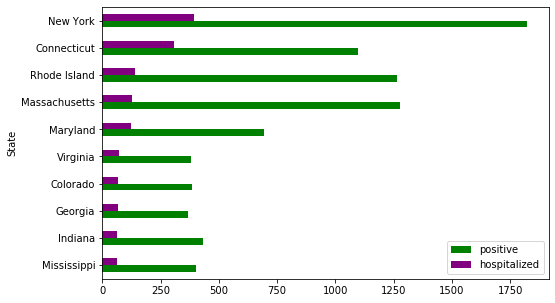

In [39]:
# bar plot top 10 states
# get most recent date
recent_date = covid_100k['date'].max()
# 10 states with largest active cases
largest_hospitalized = covid_100k[covid_100k.date == recent_date].nlargest(10, 'hospitalizedCumulative_100k')
largest_hospitalized_filter = largest_hospitalized[['state', 'positive_100k', 'hospitalizedCumulative_100k']].rename(columns={'state': 'State', 'positive_100k': 'positive', 'hospitalizedCumulative_100k': 'hospitalized'})
largest_hospitalized_filter = largest_hospitalized_filter.sort_values(by=['hospitalized']).set_index('State')
largest_hospitalized_filter.plot.barh(figsize=(8,5), color=['green', 'purple'])

In [40]:
covid_100k

,date,state,abbrev,population,dataQualityGrade,lastUpdateEt,positive_100k,active_100k,recovered_100k,death_100k,hospitalizedCurrently_100k,hospitalizedCumulative_100k,inIcuCurrently_100k,onVentilatorCurrently_100k,BedsPer100k
0,2020-05-20,Alaska,AK,734002,C,5/20/2020 00:00,54.768,53.133,47.956,1.362,2.180,nan,nan,nan,220.000
1,2020-05-20,Alabama,AL,4908621,B,5/19/2020 00:00,259.625,249.092,0.000,10.532,nan,30.416,nan,nan,310.000
2,2020-05-20,Arkansas,AR,3038999,A,5/20/2020 00:00,164.627,158.638,126.752,3.521,2.567,17.604,nan,0.461,320.000
3,2020-05-20,Arizona,AZ,7378494,A+,5/20/2020 00:00,201.898,187.992,51.135,10.124,10.978,24.287,4.039,2.819,190.000
4,2020-05-20,California,CA,39937489,B,5/20/2020 00:00,210.471,201.868,0.000,8.603,11.721,nan,3.368,nan,180.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3938,2020-01-26,Washington,WA,7797095,NaN,NaN,0.013,0.013,0.000,0.000,nan,nan,nan,nan,170.000
3939,2020-01-25,Washington,WA,7797095,NaN,NaN,0.013,0.013,0.000,0.000,nan,nan,nan,nan,170.000
3940,2020-01-24,Washington,WA,7797095,NaN,NaN,0.013,0.013,0.000,0.000,nan,nan,nan,nan,170.000
3941,2020-01-23,Washington,WA,7797095,NaN,NaN,0.013,0.013,0.000,0.000,nan,nan,nan,nan,170.000


Text(0.5, 1.0, 'Number of USA Patients Currently in ICU')

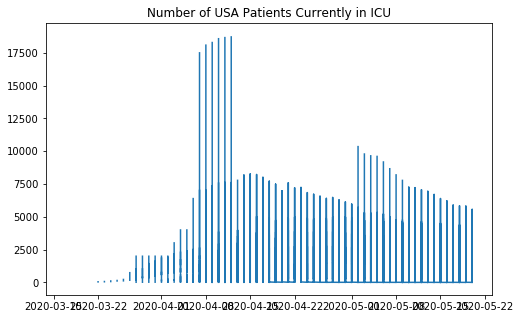

In [41]:
# Timeseries plot
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(covid_df.date, covid_df.hospitalizedCurrently)
ax.set_title('Number of USA Patients Currently in ICU')
# TODO change the X-axis to chip the year
# TODO which timeseries plots do we need?
# TODO how to temporarily remove the outliers?

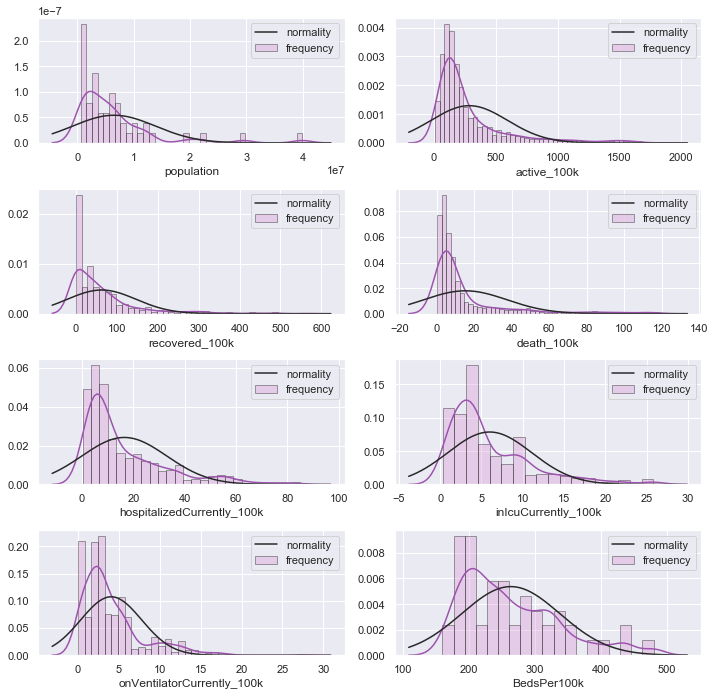

In [63]:
# get data from last day
# plot_df_last_date = plot_df.loc[covid_df['date'] == '2020-05-18'] 

# Plotting histograms to gain insight of the distribution shape, skewness and scale
fig, axs = plt.subplots(4,2,figsize = (10, 10))
sns.set()
for i, column in enumerate(plot_df_last_month.columns):
    if (i + 1) % 2 == 0:
        ax = axs[(i//2), 1]
    else:
        ax = axs[(i//2), 0]
    sns.distplot(plot_df_last_month[column], fit=norm, fit_kws=dict(label='normality'), hist_kws=dict(color='plum', edgecolor='k', linewidth=1, label='frequency'), ax=ax, color='#9d53ad')
    ax.legend(loc='upper right')
plt.tight_layout()
fig.subplots_adjust(top=0.95)

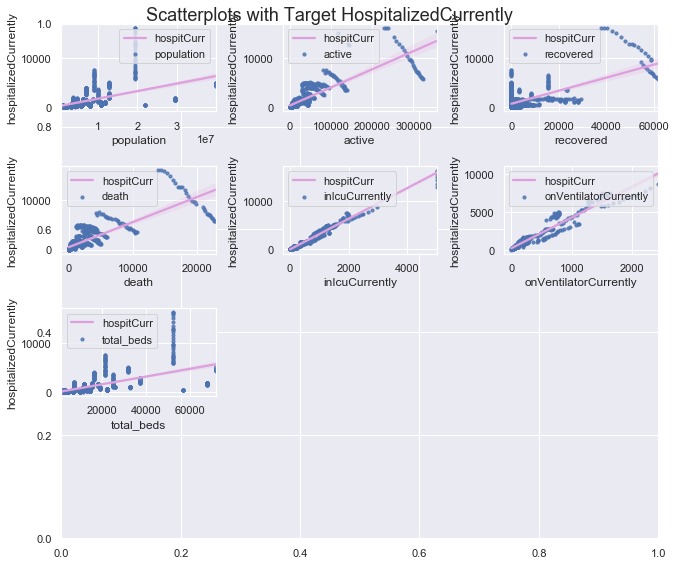

In [43]:
# Looking at linearity and variance with scatterplots
# Removing the target variable and saving it in another df
target = plot_df.hospitalizedCurrently
indep_var = plot_df.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (10, 8))
for i, col in enumerate(indep_var.columns):
    ax=fig.add_subplot(4, 3, i+1) 
    sns.regplot(x=indep_var[col], y=target, data=indep_var, label=col, scatter_kws={'s':10}, line_kws={"color": "plum", 'label': 'hospitCurr'})
    plt.suptitle('Scatterplots with Target HospitalizedCurrently', fontsize=18)
    plt.legend()
plt.tight_layout()
fig.subplots_adjust(top=0.95)

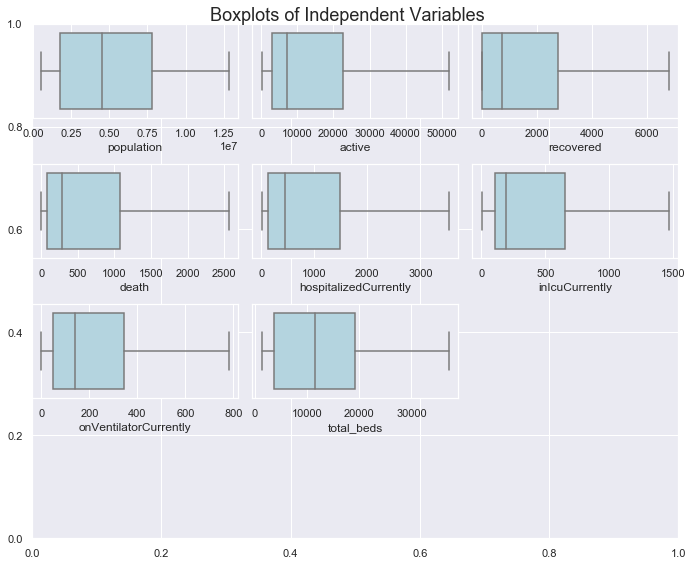

In [44]:
# Assessing the normality of the distribution with a boxplot
# Boxplot with removed outliers
fig, ax = plt.subplots(figsize = (10, 8))
for i, col in enumerate(plot_df.columns):
    ax=fig.add_subplot(4, 3, i+1) 
    sns.boxplot(x=plot_df[col], data=plot_df, color='lightblue', showfliers=False)
    plt.suptitle('Boxplots of Independent Variables', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

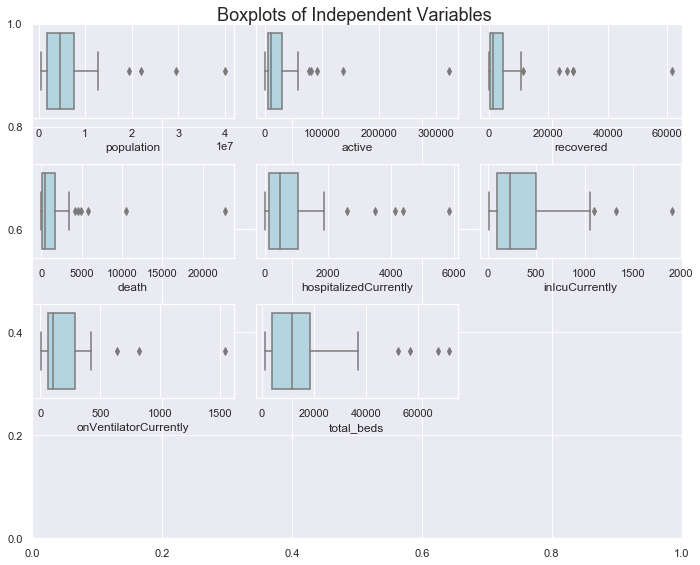

In [45]:
# get data from last day
plot_df_last_date = plot_df.loc[covid_df['date'] == '2020-05-18'] 

fig, ax = plt.subplots(figsize = (10, 8))
for i, col in enumerate(plot_df_last_date.columns):
    ax=fig.add_subplot(4, 3, i+1) 
    sns.boxplot(x=plot_df_last_date[col], data=plot_df, color='lightblue', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

## New York and California Analysis
### Since the normality of the independent variables is highly questionable, we further assess the distribution by comparing two states (NY and CA) with eachother. 
We start with constructing scatter plots and boxplots of New York.

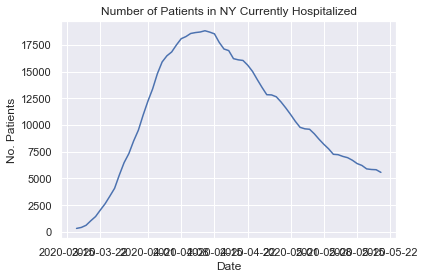

In [46]:
# Split covid_df into subset with only NY values
new_york = covid_df.loc[covid_df['abbrev'] == 'NY'] 

# Timeseries plt
plt.plot(new_york.date, new_york.hospitalizedCurrently)
plt.title('Number of Patients in NY Currently Hospitalized')
plt.xlabel('Date')
plt.ylabel('No. Patients')

# TODO the code below can be deleted once we fix the date format in plots
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

In [47]:
# Omit the categorical and date cols 
new_york = new_york[['positive', 'active', 'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]

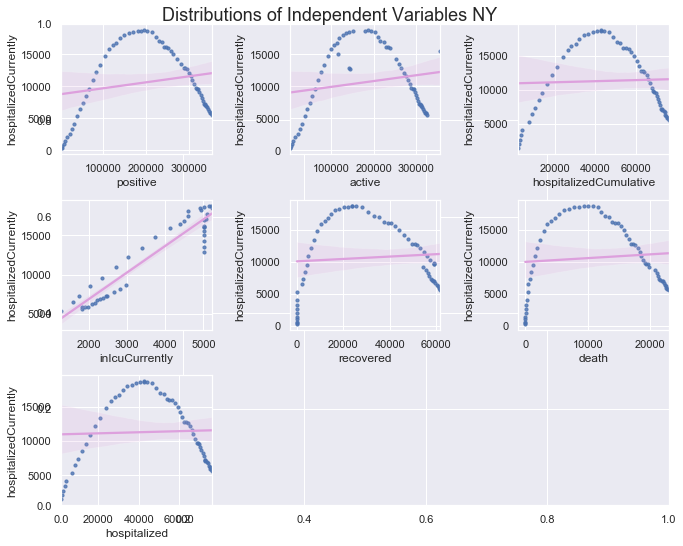

In [48]:
# Scatter plots NY
# Split dependent var from independent variables
target_ny = new_york.hospitalizedCurrently
indep_var_ny = new_york.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (10, 8))
for i, col in enumerate(indep_var_ny.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.regplot(x=indep_var_ny[col], y=target_ny, data=indep_var_ny, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables NY', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)


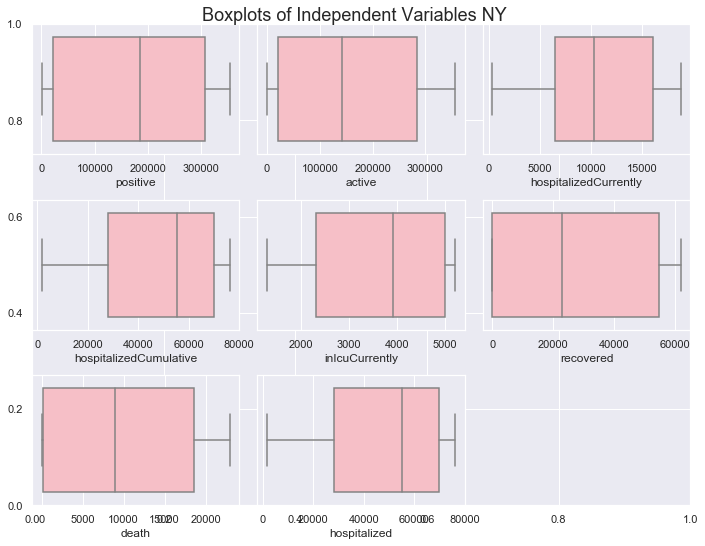

In [49]:
# Boxplot of NY
fig, ax = plt.subplots(figsize = (10, 8))
for i, col in enumerate(new_york.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=new_york[col], data=new_york, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables NY', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

### Moving onto California:

In [50]:
cali = covid_df.loc[(covid_df['abbrev'] == 'CA') & (covid_df['state']== 'California')] 


Text(0, 0.5, 'No. Patients')

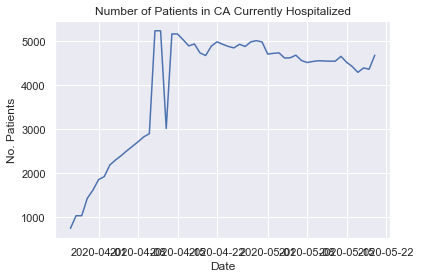

In [51]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
plt.plot(cali.date, cali.hospitalizedCurrently)
plt.title('Number of Patients in CA Currently Hospitalized')
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [52]:
# Checking which cols have NaN values
cali[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
cali.head()

# Omit the NaN cols
cali = cali[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

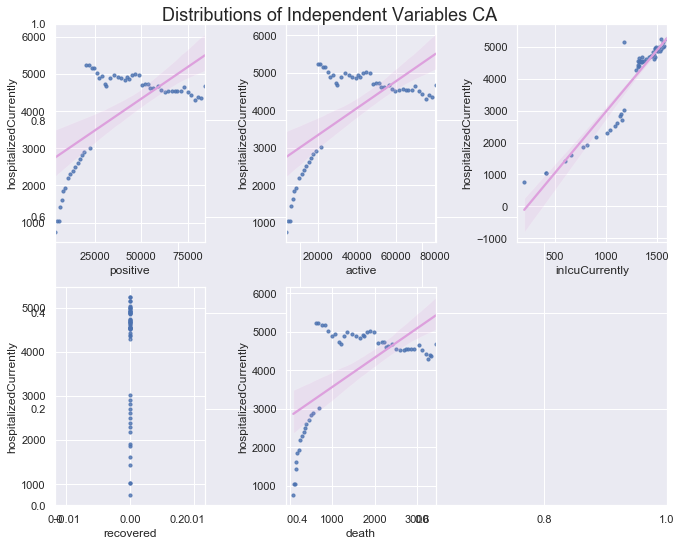

In [53]:
# Scatter plots CA
# Split dependent var from independent variables
target_ca = cali.hospitalizedCurrently
indep_var_ca = cali.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (10, 8))
for i, col in enumerate(indep_var_ca.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_ca[col], y=target_ca, data=indep_var_ca, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables CA', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

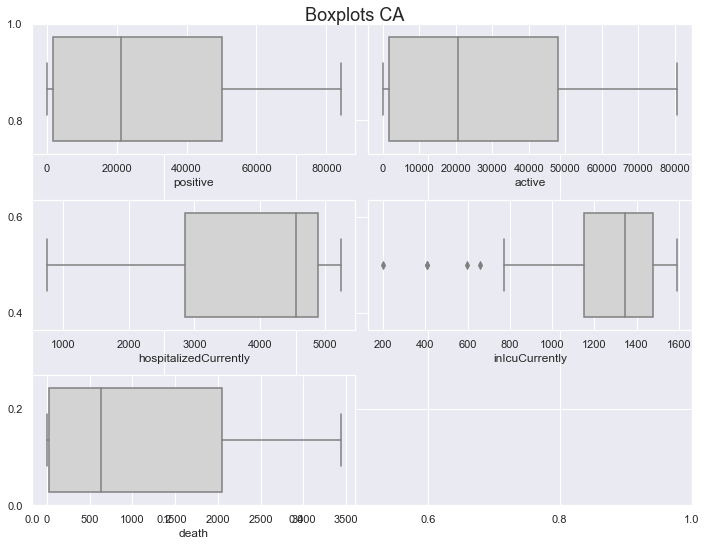

In [54]:
# Boxplot of CA
cali = cali[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'death']]
fig, ax = plt.subplots(figsize = (10, 8))
for i, col in enumerate(cali.columns):
    ax=fig.add_subplot(3, 2, i+1) 
    sns.boxplot(x=cali[col], data=cali, color='lightgrey', showfliers=True)
    plt.suptitle('Boxplots CA', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

## Assessing Correlation of Independent Variables

In [55]:
# TODO add some explanation / look more into collinear variables

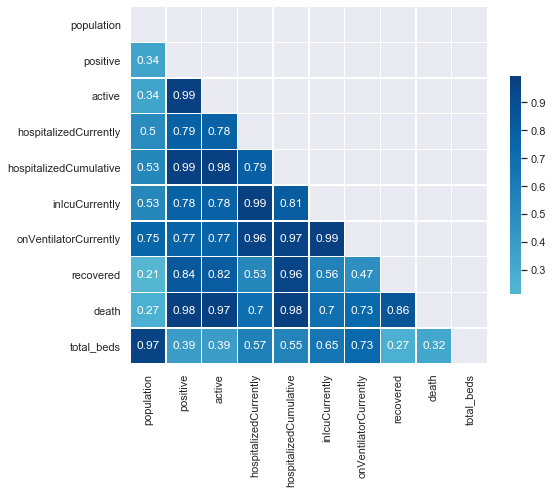

In [56]:
# Heatmap of correlations
# Save correlations to variable
corr = covid_cleaned.corr(method='pearson')
# We can create a mask to not show duplicate values
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8,8))

# Generate heatmap
sns.heatmap(corr, annot=True, mask=mask, cmap='GnBu', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Step 3: Build model for dependent Variable 
- To be used to predict hospitalizedCurrently
- Having more complete variables for inICUCurrently and onVentilatorCurrently will allow us to predict these numbers as well

In [57]:
# We compare three models:
# - Polynomial Regression
# - Linear Regression
# - ElasticNet

# Copy DFs to not mess up original one
# We will use model_df for our regression model
model_df = all_cases.copy()

# Delete redundant rows
for row in ['abbrev', 'bedsPerThousand', 'hospitalized', 
'state', 'hospitalizedCumulative', 'dataQualityGrade', 'lastUpdateEt']:
    del model_df[row]

# Drop NaN values for hospitalizedCurrently
model_df = model_df.dropna(subset=['hospitalizedCurrently'])

# Drop Values with abnormal active-hospitalised ratios (outside Conf. Interval)
model_df['ratio_hospital'] = model_df['hospitalizedCurrently'] / model_df['active']
model_df = model_df[~(model_df['ratio_hospital'] >= model_df.ratio_hospital.quantile(0.99))]

#model_df = model_df[~(model_df['ratio_hospital'] <= model_df['ratio_hospital'].median())]
del model_df['ratio_hospital']

# Get peek of model to use
model_df.describe()

,population,positive,active,hospitalizedCurrently,inIcuCurrently,onVentilatorCurrently,recovered,death,total_beds
count,1852.000,1852.000,1852.000,1852.000,932.000,756.000,1852.000,1852.000,1852.000
mean,7046271.562,22313.741,20633.876,1333.606,589.275,313.524,3152.183,1191.552,16597.438
std,8221726.911,47509.921,43260.735,2493.084,900.878,432.396,8445.147,2919.767,17430.169
min,567025.000,115.000,115.000,3.000,2.000,0.000,0.000,0.000,1318.928
25%,1778070.000,1751.500,1671.250,101.000,96.000,30.000,0.000,51.000,3773.952
50%,4499692.000,6545.500,6212.000,407.000,187.500,115.500,430.500,253.000,11557.920
75%,8626207.000,22472.250,21177.000,1496.000,813.250,440.000,2032.000,971.500,19124.737
max,39937489.000,354370.000,356899.000,18825.000,5225.000,2425.000,61886.000,22976.000,71887.480


## One last thing:

Get all combinations of independent params

In [58]:
import itertools

# High train-test split = more data unknown to model
split = 0.3

independent_cols = [x for x in list(model_df.columns) if not(x in ['hospitalizedCurrently', 'inIcuCurrently', 'onVentilatorCurrently', 'date'])]

comb_list = []
len_ind = len(independent_cols)
for i in range(len_ind):
    sub_list = list(itertools.combinations(independent_cols, len_ind-i))
    comb_list += list(list(x) for x in sub_list)

### Model 1: Polynomial Regression

In [59]:
from sklearn.metrics import r2_score

mse_df1 = {'param_comb': [],
'degree': [],
'score': [],
'mean_abs_err': [],
'r_squared': []}

degrees = [2, 3]

for comb in comb_list:
    X = model_df[comb]
    y = model_df['hospitalizedCurrently']

    for d in degrees:

        polynomial_features = PolynomialFeatures(degree=d)
        x_poly = polynomial_features.fit_transform(X)

        model = LinearRegression()
        model.fit(x_poly, y)
        y_poly_pred = model.predict(x_poly)

        mse_df1['param_comb'].append(comb)
        mse_df1['score'].append(np.sqrt(mean_squared_error(y, y_poly_pred)))
        mse_df1['degree'].append(d)
        mse_df1['mean_abs_err'].append(mean_absolute_error(y, y_poly_pred))
        mse_df1['r_squared'].append(r2_score(y, y_poly_pred))

mse_df1 = pd.DataFrame(mse_df1)
mse_df1.sort_values(by='r_squared', ascending=False).head()

,param_comb,degree,score,mean_abs_err,r_squared
1,"[population, positive, active, recovered, deat...",3,449.173,282.416,0.968
13,"[positive, active, recovered, death, total_beds]",3,488.745,289.157,0.962
41,"[positive, recovered, death, total_beds]",3,501.535,295.251,0.960
43,"[active, recovered, death, total_beds]",3,527.688,294.549,0.955
7,"[population, positive, active, death, total_beds]",3,574.440,351.451,0.947


The scores achieved by the polynomial model are suspiciously good. The errors are relatively low, and $R^2 \xrightarrow{} 1$. 

This indicates that we may be explaining the errors, rather than the data itself. This is a big warning sign that the polynomial model is overfitting.

### Model 2: Linear Regression

In [60]:
import itertools

mse_df = {'param_comb': [],
'score': [],
'mean_abs_err': [],
'r_squared': []}

for comb in comb_list:
    # Independent vars
    X = model_df[comb]

    # Dependent var
    y = model_df['hospitalizedCurrently']

    # Fit model
    linear_model = LinearRegression()
    linear_model.fit(X, y)

    y_pred = linear_model.predict(X)
    
    mse_df['param_comb'].append(comb)
    mse_df['score'].append(np.sqrt((mean_squared_error(y, y_pred))))
    mse_df['mean_abs_err'].append(mean_absolute_error(y, y_pred))
    mse_df['r_squared'].append(r2_score(y, y_pred))
mse_df = pd.DataFrame(mse_df)
mse_df.sort_values(by='r_squared', ascending=False).head()

,param_comb,score,mean_abs_err,r_squared
0,"[population, positive, active, recovered, deat...",1110.264,573.642,0.802
4,"[population, positive, recovered, death, total...",1111.027,573.953,0.801
6,"[positive, active, recovered, death, total_beds]",1112.547,571.439,0.801
20,"[positive, recovered, death, total_beds]",1113.322,571.715,0.800
1,"[population, positive, active, recovered, death]",1113.487,575.102,0.800


This time, simple linear regression seems to work better. $R^2 \approx 0.87$ is a good score, indicative of high correlation between the dependent variable and all describing variables. 

It is possible to reduce the errors and maintain a good fit.

### Model 3: ElasticNet Regression

Cross-validate every combination (Look for best hyperparams first)

In [61]:
cross_val_results = {
    'columns': [],
    'alpha': [],
    'l1_ratio': []
}

for ind_cols in comb_list:
    X = model_df[ind_cols]
    y = model_df['hospitalizedCurrently']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)

    # Seek best params like we seek the COVID vaccine
    elastic = ElasticNet(normalize=True, max_iter=10000)
    search=GridSearchCV(estimator=elastic,param_grid={
        'alpha':np.logspace(-5, 2, 8),
        'l1_ratio':[.1, .2, .4, .6, .75, .8, .85, .9, .95, 1]},
        scoring='neg_mean_absolute_error',
        n_jobs=1,
        refit=True,
        cv=10)

    search.fit(X_train,y_train)
    cross_val_results['columns'].append(ind_cols)
    cross_val_results['alpha'].append(search.best_params_['alpha'])
    cross_val_results['l1_ratio'].append(search.best_params_['l1_ratio'])

cross_val_results = pd.DataFrame(cross_val_results)

KeyboardInterrupt: 

In [60]:
score = []
mean_abs_err = []
r2_list = []

for i, row in cross_val_results.iterrows():
    alpha = cross_val_results.at[i, 'alpha']
    l1 = cross_val_results.at[i, 'l1_ratio']

    X = model_df[cross_val_results.at[i, 'columns']]
    y = model_df['hospitalizedCurrently']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)
    elastic = ElasticNet(normalize=True, alpha=alpha, l1_ratio=l1, max_iter=1000000)
    elastic.fit(X_train,y_train)

    rmse = (np.sqrt(mean_squared_error(y_true=y_test,y_pred=elastic.predict(X_test))))
    mae = mean_absolute_error(y_true=y_test, y_pred=elastic.predict(X_test))
    r2 = r2_score(y_test, elastic.predict(X_test))

    score.append(rmse)
    mean_abs_err.append(mae)
    r2_list.append(r2)

cross_val_results['score'] = score
cross_val_results['mean_abs_err'] = mean_abs_err
cross_val_results['r_squared'] = r2_list

cross_val_results.sort_values(by='r_squared', ascending=False).head()

,columns,alpha,l1_ratio,score,mean_abs_err,r_squared
4,"[population, positive, recovered, death, total...",0.000,0.750,1047.896,560.706,0.817
17,"[positive, active, recovered, death]",0.000,0.900,1302.272,635.212,0.797
12,"[population, positive, death, total_beds]",0.000,0.400,1080.778,542.005,0.793
24,"[population, positive, death]",0.000,0.950,1184.809,588.842,0.789
6,"[positive, active, recovered, death, total_beds]",0.000,0.400,1235.977,554.593,0.777


In [61]:
from sklearn.model_selection import KFold

# TODO update params for this section
X = model_df[['population', 'positive', 'active', 'recovered', 'death', 'total_beds']]
y = model_df['hospitalizedCurrently']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)
elastic = ElasticNet(normalize=True, alpha=0.00001, l1_ratio=0.60, max_iter=10000)
elastic.fit(X_train, y_train)
pred = elastic.predict(X_test)

rmse = (np.sqrt(mean_squared_error(y_true=y_test,y_pred=pred)))
mae = mean_absolute_error(y_true=y_test, y_pred=pred)
r2 = r2_score(y_test, pred)


print(f"RMSE: {rmse}, MAE: {mae}, r2:{r2}")
print(f"Intercept: {elastic.intercept_}, Coefficients: {elastic.coef_}")

print(f"\n\n{elastic.get_params()}")

RMSE: 1135.8900098899094, MAE: 563.1360916724999, r2:0.7885649503901339
Intercept: 16.81950124374771, Coefficients: [-4.44895232e-05  9.53616529e-02  2.21838307e-02 -6.56915269e-02
 -1.12670977e+00  3.61281163e-02]


{'alpha': 1e-05, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.6, 'max_iter': 10000, 'normalize': True, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


In the end, ElasticNet stroke the balance perfectly.

Whilst $R^2 \approx 0.87$ is indeed lower than the linear regression model, this is still a good fit. 

We also managed to reduce the errors, thanks to the ElasticNet's penalising measures which can help reduce the error but maintain a good fit.

Testing against unseen data further verifies ElasticNet's reliability.

## Step 4: Using findings from dataset of hospital beds, conclude research problem

In [62]:
# TODO specific correlation tests for hospitalisedCurrently vs. ICU & hospitalisedCurrently vs. Ventilator